# Logistic Regression with Python

For this lecture we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set and very often is a student's first step in machine learning! 

We'll be trying to predict a classification- survival or deceased.
Let's begin our understanding of implementing Logistic Regression in Python for classification.

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning not shown in this lecture notebook.

## Import Libraries
Let's import some libraries to get started!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,\
precision_score,recall_score,f1_score


## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [2]:
data = pd.read_csv('titanic.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

<Axes: >

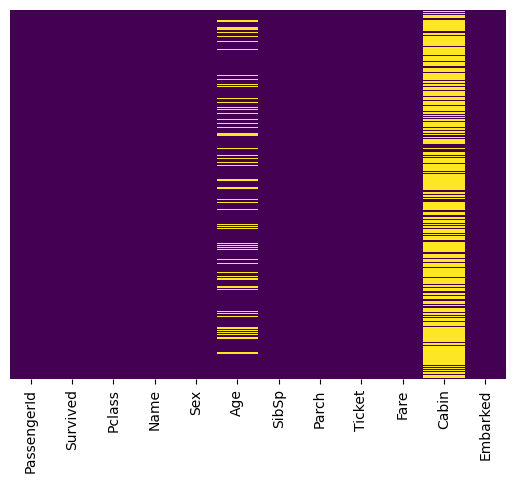

In [4]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data! Check out the video for full explanations over these plots, this code is just to serve as reference.

<Axes: xlabel='Survived', ylabel='count'>

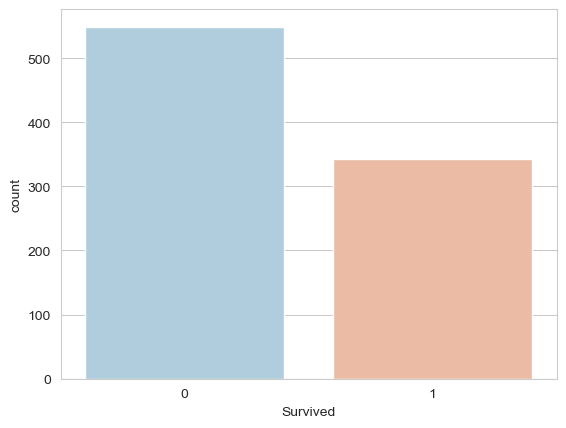

In [5]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=data,palette='RdBu_r')

In [6]:
data.Survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

<Axes: xlabel='Survived', ylabel='count'>

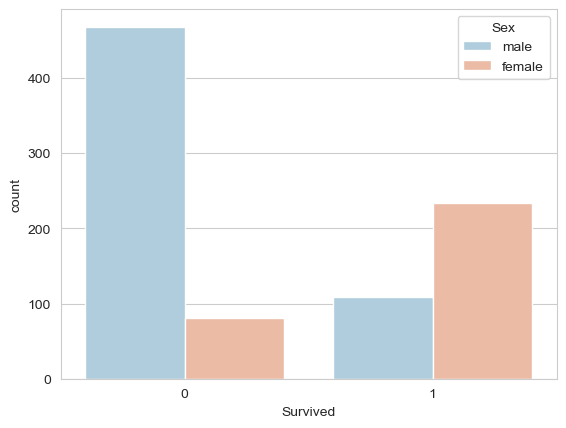

In [7]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=data,palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

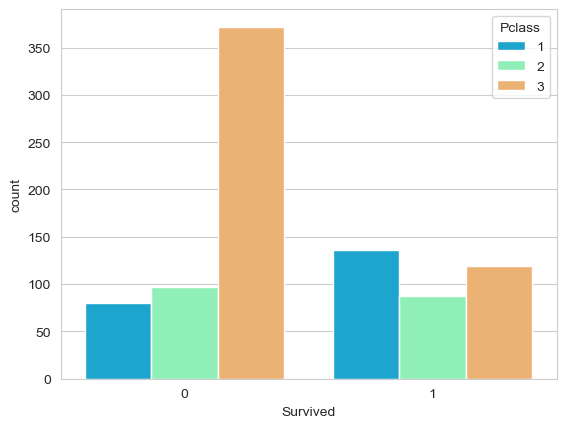

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=data,palette='rainbow')

C:\Users\kk\AppData\Local\Temp\ipykernel_11260\302500387.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Age'].dropna(),kde=True,color='darkred',bins=30)


<Axes: xlabel='Age', ylabel='Density'>

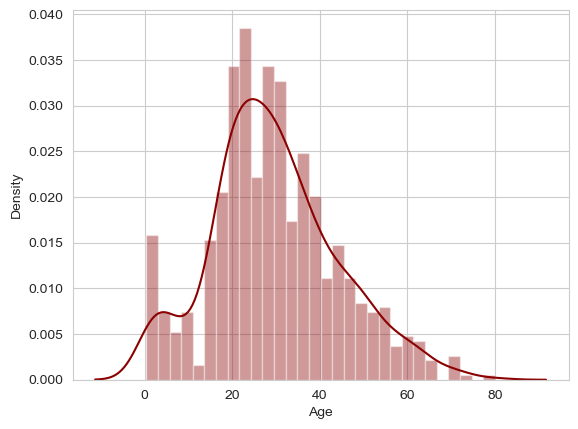

In [9]:
sns.distplot(data['Age'].dropna(),kde=True,color='darkred',bins=30)

<Axes: xlabel='SibSp', ylabel='count'>

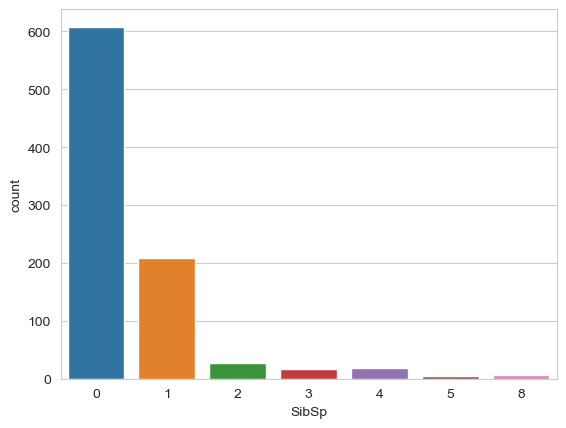

In [10]:
sns.countplot(x='SibSp',data=data)

<Axes: >

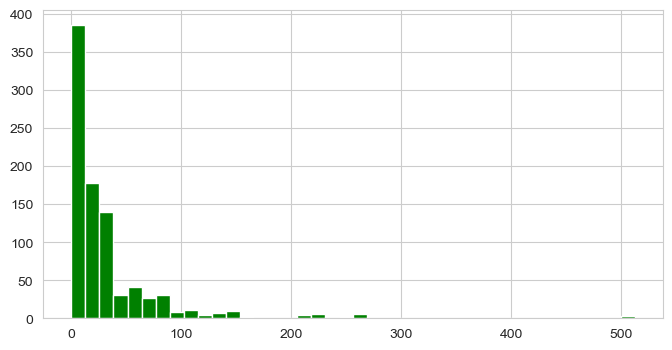

In [11]:
data['Fare'].hist(color='green',bins=40,figsize=(8,4))

___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


<Axes: xlabel='Pclass', ylabel='Age'>

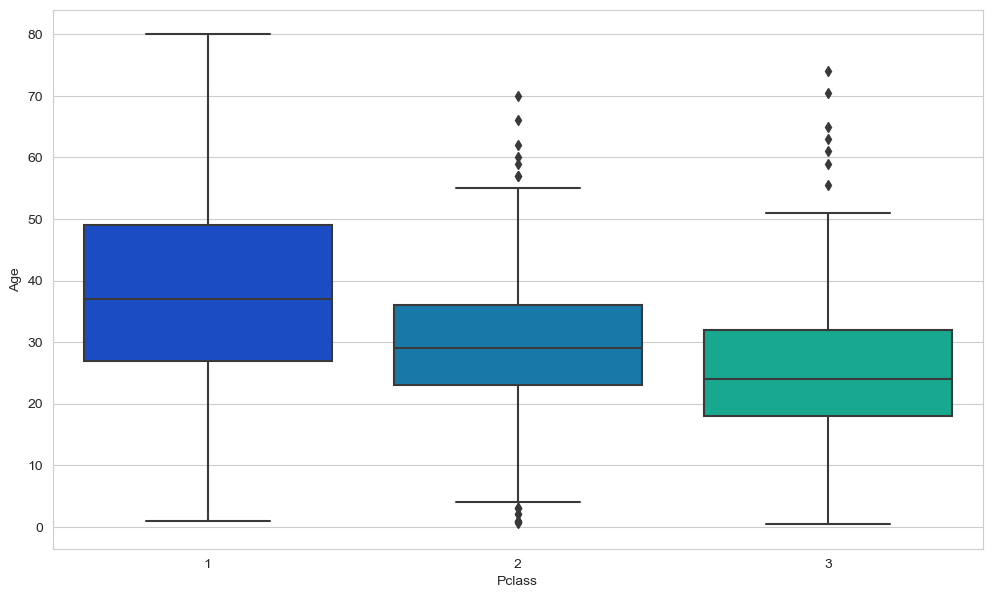

In [12]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=data,palette='winter')

In [13]:
data1 = data.copy()
data1.dropna(inplace=True)

Now let's check that heat map again!

In [14]:
data1.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [15]:
data1.shape

(183, 12)

## Extracting Feature Array & Taget Column

In [16]:
data1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [17]:
X = data1[['Age','SibSp','Parch','Fare','Pclass']] # Feature Array
y = data1['Survived']                              # Target Column

Great! Our data is ready for our model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [18]:
# Splitting data into Training & testing sets

X_tr,X_te,y_tr,y_te = \
train_test_split(X,y,test_size=0.25,random_state=42)

In [19]:
print("Total Rows in X: ", X.shape[0])
print("Total Rows in X_train: ", X_tr.shape[0])
print("Total Rows in X_test: ", X_te.shape[0])

Total Rows in X:  183
Total Rows in X_train:  137
Total Rows in X_test:  46


## Training and Predicting

In [22]:
# Building the model

regmod = LogisticRegression()

In [23]:
# Training the model

regmod.fit(X_tr,y_tr)

LogisticRegression()

In [24]:
y_pred = regmod.predict(X_te)
y_pred[:5]

array([1, 1, 1, 1, 1], dtype=int64)

Let's move on to evaluate our model!

## Evaluation

In [25]:
# Creating a confusion matrix

conf_matirx = confusion_matrix(y_te,y_pred)
conf_matirx

array([[ 2, 16],
       [ 0, 28]], dtype=int64)

## Visualizing Confusion Matrix

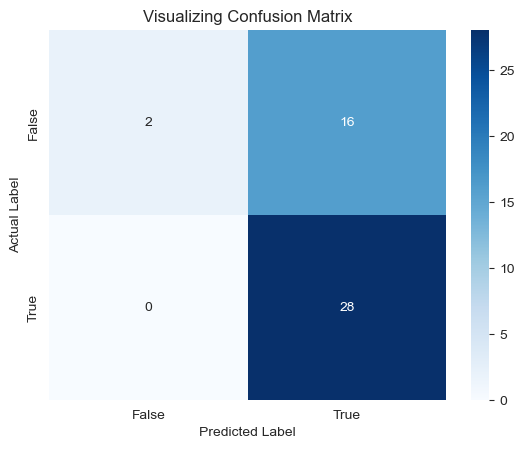

In [26]:
ax = sns.heatmap(conf_matirx,annot=True,cmap="Blues")
ax.set_title("Visualizing Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Actual Label")

ax.xaxis.set_ticklabels(["False","True"])
ax.yaxis.set_ticklabels(["False","True"])

plt.show()

In [27]:
## Performance metrices

print("Acc Score ", accuracy_score(y_te,y_pred))
print("Pre Score ", precision_score(y_te,y_pred))
print("Rec Score ", recall_score(y_te,y_pred))
print("F1-Score ", f1_score(y_te,y_pred))

Acc Score  0.6521739130434783
Pre Score  0.6363636363636364
Rec Score  1.0
F1-Score  0.7777777777777778


In [28]:
confusion_matrix(y_te,y_pred,labels=[1,0])

array([[28,  0],
       [16,  2]], dtype=int64)

We can check precision,recall,f1-score using classification report!

In [29]:
from sklearn.metrics import classification_report

In [105]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.81      0.93      0.86       163
          1       0.85      0.65      0.74       104

avg / total       0.82      0.82      0.81       267



Not so bad! You might want to explore other feature engineering and the other titanic_text.csv file, some suggestions for feature engineering:

* Try grabbing the Title (Dr.,Mr.,Mrs,etc..) from the name as a feature
* Maybe the Cabin letter could be a feature
* Is there any info you can get from the ticket?

## Calculate the AUC

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = regmod.predict_proba(X_te)[::,1]
y_pred_proba

array([0.89965561, 0.5323922 , 0.8601162 , 0.68384215, 0.62232713,
       0.43538425, 0.82275036, 0.79044873, 0.69307158, 0.55765099,
       0.5323797 , 0.63715702, 0.64241208, 0.64568721, 0.53945889,
       0.74770263, 0.84273509, 0.67252994, 0.62066346, 0.8645524 ,
       0.79499767, 0.8141604 , 0.65154547, 0.78447668, 0.43047379,
       0.76762756, 0.74511796, 0.65096209, 0.6987026 , 0.60413488,
       0.81364135, 0.86660669, 0.71206106, 0.79435489, 0.76113472,
       0.59440758, 0.76214477, 0.62863808, 0.76923503, 0.77528036,
       0.67176699, 0.61667451, 0.83540055, 0.66744622, 0.55730677,
       0.62528485])

In [35]:
# Calculating AUC of model

auc = roc_auc_score(y_te,y_pred_proba)
fpr,tpr,_ = roc_curve(y_te, y_pred_proba)

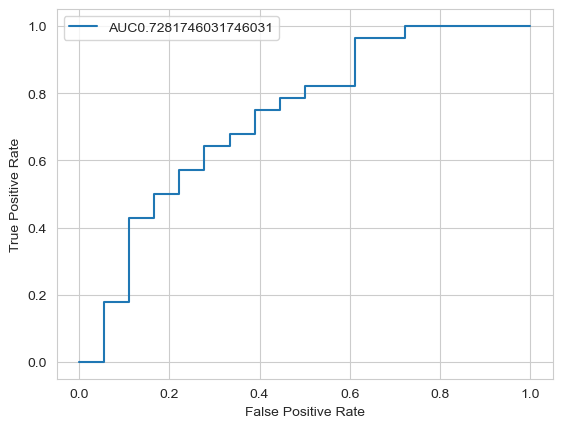

In [36]:
# Creating ROC Curve

import matplotlib.pyplot as plt

plt.plot(fpr,tpr,label="AUC"+str(auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()